# VNNLib Benchmark Visualization
Demonstrate ACT's VNNLib loader with ACAS Xu network visualization

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## VNNLib ACAS Xu Perturbation Visualization

This section demonstrates:
- Loading ACAS Xu networks from VNNLib benchmarks
- Parsing VNNLIB specifications for input bounds
- Visualizing input specifications as bar charts
- Testing network behavior on sample points
- Interpreting ACAS Xu collision avoidance outputs

Loading ACAS Xu network and specification...



onnxsim not available, skipping simplification


✓ Model loaded: <class 'onnx2pytorch.convert.model.ConvertModel'>
✓ Input tensor shape: torch.Size([1, 1, 5])
✓ VNNLib metadata: 5 inputs, 5 outputs
✓ Property type: unknown


/Users/z3310488/miniconda3/envs/act-py312/lib/python3.12/site-packages/onnx2pytorch/convert/operations.py:156: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1729646995093/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  weight = torch.from_numpy(numpy_helper.to_array(params[0]))


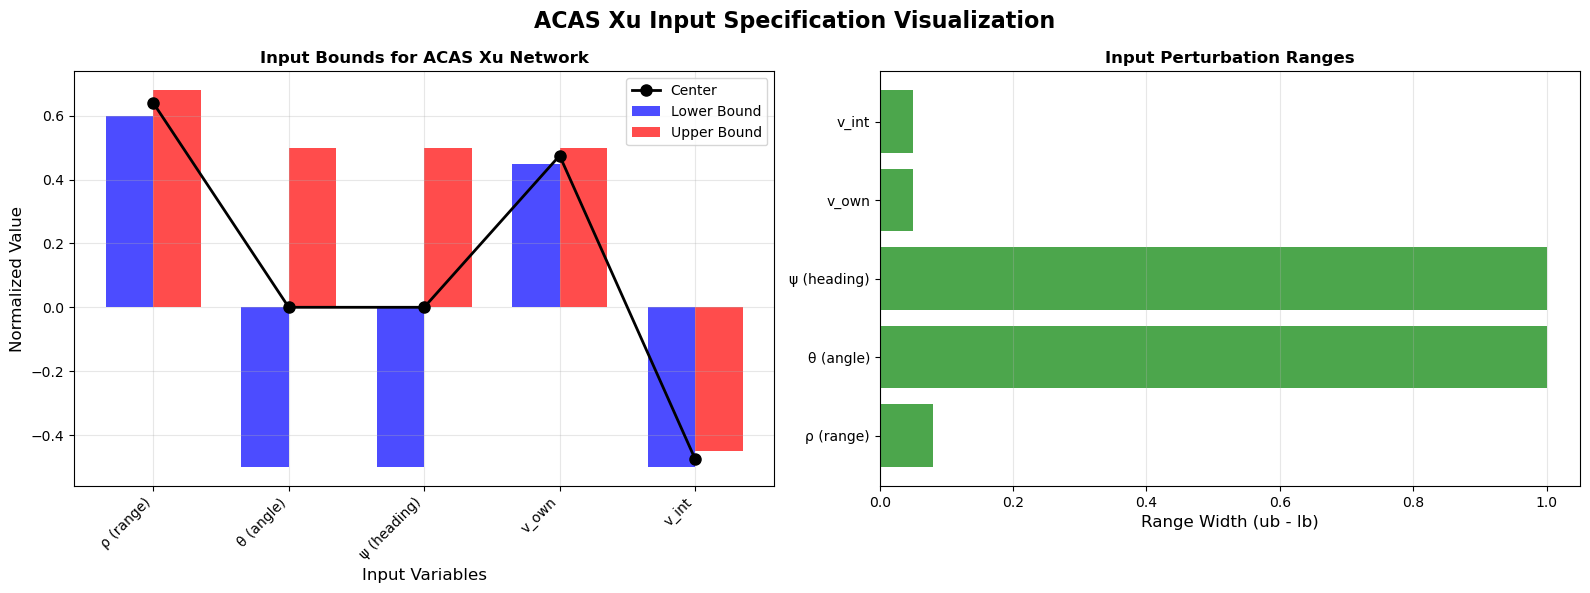


Testing Network on Sample Points

Lower Bound:
  Input: [ 0.6  -0.5  -0.5   0.45 -0.5 ]
  Output: [-0.0202845 -0.0193085 -0.019157  -0.0189128 -0.0189197]
  Recommended Action: Strong Left

Center:
  Input: [ 0.6399289  0.         0.         0.475     -0.475    ]
  Output: [-0.0203966  -0.01847511 -0.01822628 -0.01796024 -0.01798192]
  Recommended Action: Strong Left

Upper Bound:
  Input: [ 0.6798578  0.5        0.5        0.5       -0.45     ]
  Output: [-0.0202845 -0.0193085 -0.019157  -0.0189128 -0.0189197]
  Recommended Action: Strong Left

✓ Tested ACAS Xu network on 3 sample points
  Input dimension: 5
  Output dimension: 5


In [2]:
# ACT VNNLib: Visualize ACAS Xu Specs and Test Robustness
import sys
import os

# Setup ACT paths
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
if act_root not in sys.path:
    sys.path.insert(0, act_root)

import torch
import matplotlib.pyplot as plt
import numpy as np
from act.front_end.vnnlib_loader.data_model_loader import load_vnnlib_pair
from act.front_end.vnnlib_loader.create_specs import VNNLibSpecCreator

# Load ACAS Xu model and spec
print("Loading ACAS Xu network and specification...\n")
try:
    # Try to load an ACAS Xu example
    vnnlib_pair = load_vnnlib_pair(
        category="acasxu_2023",
        onnx_model="ACASXU_run2a_1_2_batch_2000.onnx",
        vnnlib_spec="prop_1.vnnlib"
    )
    
    model = vnnlib_pair['model']
    input_tensor = vnnlib_pair['input_tensor']
    vnnlib_metadata = vnnlib_pair['vnnlib_metadata']
    
    print(f"✓ Model loaded: {type(model)}")
    print(f"✓ Input tensor shape: {input_tensor.shape}")
    print(f"✓ VNNLib metadata: {vnnlib_metadata['num_inputs']} inputs, {vnnlib_metadata['num_outputs']} outputs")
    print(f"✓ Property type: {vnnlib_metadata['property_type']}")
    
    # ACAS Xu has 5 inputs (normalized relative position/velocity)
    # Extract bounds from vnnlib_metadata
    input_names = ['ρ (range)', 'θ (angle)', 'ψ (heading)', 'v_own', 'v_int']
    input_bounds = vnnlib_metadata['input_bounds']
    
    # Convert bounds dict to arrays
    num_inputs = vnnlib_metadata['num_inputs']
    lb = np.array([input_bounds[i][0] if i in input_bounds else 0.0 for i in range(num_inputs)])
    ub = np.array([input_bounds[i][1] if i in input_bounds else 0.0 for i in range(num_inputs)])
    center = (lb + ub) / 2
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    fig.suptitle('ACAS Xu Input Specification Visualization', fontsize=16, fontweight='bold')
    
    # Plot 1: Input bounds as bar chart
    x = np.arange(len(input_names))
    width = 0.35
    
    axes[0].bar(x - width/2, lb, width, label='Lower Bound', color='blue', alpha=0.7)
    axes[0].bar(x + width/2, ub, width, label='Upper Bound', color='red', alpha=0.7)
    axes[0].plot(x, center, 'ko-', label='Center', linewidth=2, markersize=8)
    
    axes[0].set_xlabel('Input Variables', fontsize=12)
    axes[0].set_ylabel('Normalized Value', fontsize=12)
    axes[0].set_title('Input Bounds for ACAS Xu Network', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(input_names, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Input range widths
    ranges = ub - lb
    axes[1].barh(input_names, ranges, color='green', alpha=0.7)
    axes[1].set_xlabel('Range Width (ub - lb)', fontsize=12)
    axes[1].set_title('Input Perturbation Ranges', fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    # Test with 3 sample points: lower bound, center, upper bound
    print("\n" + "="*70)
    print("Testing Network on Sample Points")
    print("="*70)
    
    test_points = {
        'Lower Bound': torch.from_numpy(lb).float().unsqueeze(0),
        'Center': torch.from_numpy(center).float().unsqueeze(0),
        'Upper Bound': torch.from_numpy(ub).float().unsqueeze(0)
    }
    
    model.eval()
    with torch.no_grad():
        for name, point in test_points.items():
            output = model(point)
            action = output.argmax(dim=1).item()
            action_names = ['Clear-of-Conflict', 'Weak Left', 'Weak Right', 
                           'Strong Left', 'Strong Right']
            print(f"\n{name}:")
            print(f"  Input: {point.numpy().flatten()}")
            print(f"  Output: {output.numpy().flatten()}")
            print(f"  Recommended Action: {action_names[action]}")
    
    print("\n" + "="*70)
    print(f"✓ Tested ACAS Xu network on {len(test_points)} sample points")
    print(f"  Input dimension: {len(lb)}")
    print(f"  Output dimension: {output.shape[1]}")
    
except Exception as e:
    print(f"⚠ Could not load ACAS Xu example: {e}")
    print("\nNote: ACAS Xu models require:")
    print("  1. ONNX model file (.onnx)")
    print("  2. VNNLib specification file (.vnnlib)")
    print("  3. Proper paths in data/vnnlib/ directory")
    print("\nFalling back to CIFAR10 visualization...")
    
    # Fallback: Show CIFAR10 as alternative
    cifar_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True,
        transform=transforms.ToTensor()
    )
    
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    fig, axes = plt.subplots(2, 5, figsize=(12, 5))
    fig.suptitle('CIFAR10 Dataset - First 10 Images (Fallback)', fontsize=16)
    
    for idx, ax in enumerate(axes.flat):
        img, label = cifar_dataset[idx]
        img = img.numpy().transpose(1, 2, 0)
        ax.imshow(img)
        ax.set_title(f'{class_names[label]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nCIFAR10 Dataset size: {len(cifar_dataset)}")
    print(f"Image shape: {cifar_dataset[0][0].shape}")

## Understanding VNNLib Specifications

VNNLib specifications use SMT-LIB format to define:
- Input constraints (box bounds, L∞ perturbations)
- Output properties (safety, robustness)
- Verification tasks for standardized benchmarks

In [1]:
print("="*70)
print("VNNLib Benchmark Approach")
print("="*70)
print("""
✓ **STANDARDIZED BENCHMARKS**: Pre-defined verification tasks
  - ACAS Xu: Aircraft collision avoidance (5 inputs, 5 outputs)
  - VNN-COMP: Competition benchmarks for fair comparison
  - Multiple domains: MNIST, CIFAR, control systems

✓ **SPECIFICATIONS IN SMT-LIB**: Formal constraint definitions
  - Input bounds: (assert (>= X_0 0.6)) (assert (<= X_0 0.68))
  - Output properties: Safety conditions, robustness requirements
  - Property types: Local vs. global specifications

✓ **VERIFICATION WORKFLOW**: 
  1. Load ONNX model and VNNLIB spec
  2. Parse input bounds from SMT-LIB assertions
  3. Convert to internal format (tensors, metadata)
  4. Run verification with specified property
  5. Return SAT/UNSAT/UNKNOWN result

This approach is ideal for:
  • Research paper benchmarking
  • Competition participation (VNN-COMP)
  • Reproducible verification results
  • Standardized tool comparison

CONTRAST WITH TORCHVISION:
  • VNNLib: Fixed specs, standardized benchmarks, SMT-LIB format
  • TorchVision: Custom specs, flexible datasets, Python API
  • Both valid: Use VNNLib for benchmarks, TorchVision for custom tasks
""")

VNNLib Benchmark Approach

✓ **STANDARDIZED BENCHMARKS**: Pre-defined verification tasks
  - ACAS Xu: Aircraft collision avoidance (5 inputs, 5 outputs)
  - VNN-COMP: Competition benchmarks for fair comparison
  - Multiple domains: MNIST, CIFAR, control systems

✓ **SPECIFICATIONS IN SMT-LIB**: Formal constraint definitions
  - Input bounds: (assert (>= X_0 0.6)) (assert (<= X_0 0.68))
  - Output properties: Safety conditions, robustness requirements
  - Property types: Local vs. global specifications

✓ **VERIFICATION WORKFLOW**: 
  1. Load ONNX model and VNNLIB spec
  2. Parse input bounds from SMT-LIB assertions
  3. Convert to internal format (tensors, metadata)
  4. Run verification with specified property
  5. Return SAT/UNSAT/UNKNOWN result

This approach is ideal for:
  • Research paper benchmarking
  • Competition participation (VNN-COMP)
  • Reproducible verification results
  • Standardized tool comparison

CONTRAST WITH TORCHVISION:
  • VNNLib: Fixed specs, standardized ben

## CIFAR-100 VNNLib Benchmark Test

Test fully-trained CIFAR-100 models from VNNLib benchmarks.
These models are trained on CIFAR-100 (not ImageNet pre-trained), so they should provide meaningful predictions.

TESTING CIFAR-100 VNNLIB MODEL
Files already downloaded and verified
Files already downloaded and verified


onnxsim not available, skipping simplification


✓ CIFAR-100 dataset loaded: 10000 test samples
✓ VNNLib model loaded: ConvertModel
✓ Testing with 20 random samples (normalization: mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])



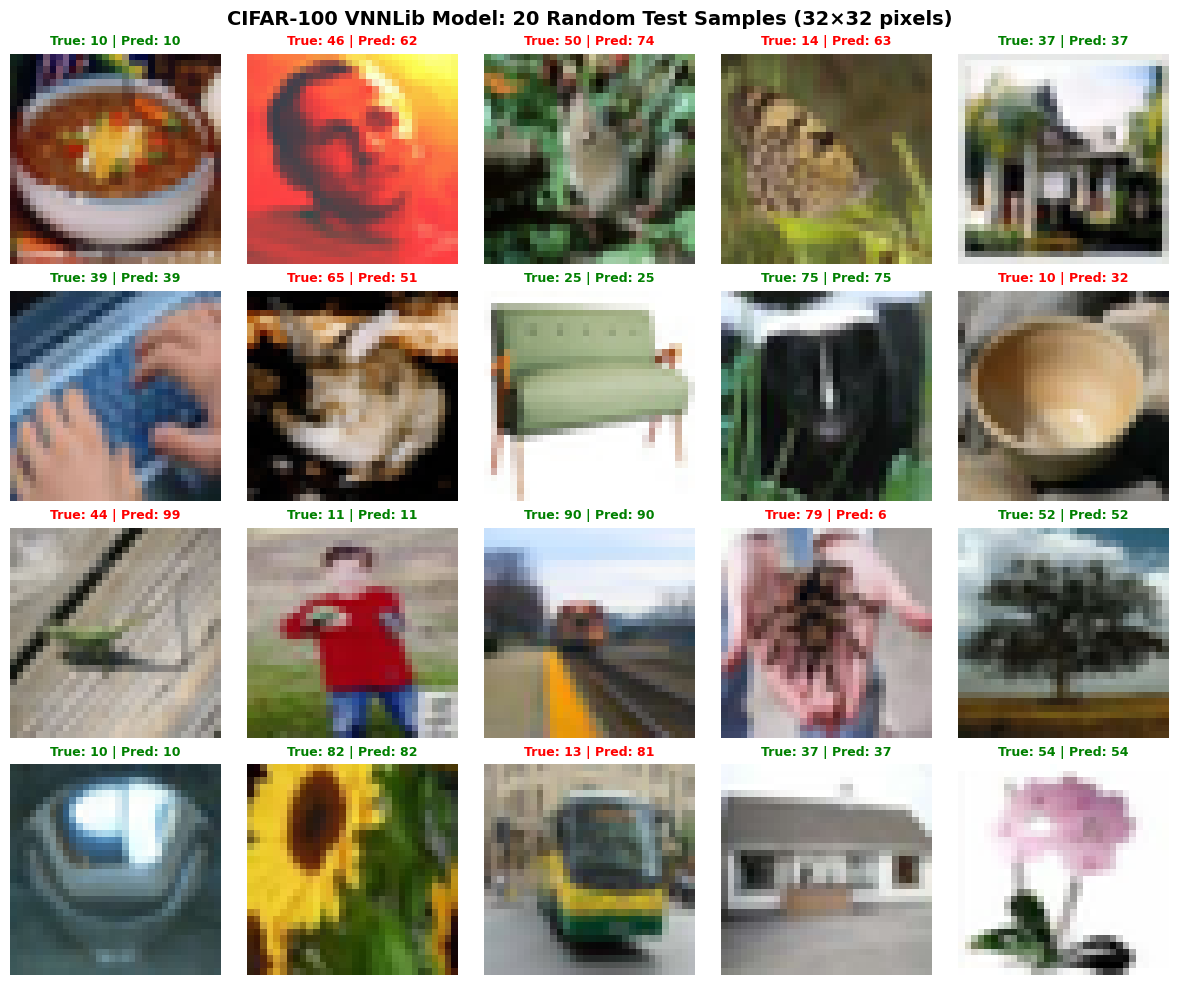

RESULTS: 12/20 correct (60.0% accuracy)

ℹ️  CIFAR-100 has 100 classes (random guess: 1% accuracy)
   Expected accuracy for trained model: 60-80%
   Actual accuracy: 60.0%

✓ Model is working correctly!


In [2]:
# Test CIFAR-100 VNNLib Model with Random Samples
import sys
import os
act_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
if act_root not in sys.path:
    sys.path.insert(0, act_root)

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from act.front_end.vnnlib_loader.data_model_loader import load_vnnlib_pair

print("="*100)
print("TESTING CIFAR-100 VNNLIB MODEL")
print("="*100)

# CIFAR-100 normalization and dataset
CIFAR100_MEAN = [0.5071, 0.4867, 0.4408]
CIFAR100_STD = [0.2675, 0.2565, 0.2761]
cifar100_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transforms.ToTensor()
)
normalize = transforms.Normalize(mean=CIFAR100_MEAN, std=CIFAR100_STD)

print(f"✓ CIFAR-100 dataset loaded: {len(cifar100_dataset)} test samples")

try:
    # Load VNNLib model
    vnnlib_pair = load_vnnlib_pair(
        category="cifar100_2024",
        onnx_model="CIFAR100_resnet_medium.onnx",
        vnnlib_spec="CIFAR100_resnet_medium_prop_idx_1401_sidx_3081_eps_0.0039.vnnlib"
    )
    model = vnnlib_pair['model']
    model.eval()
    
    print(f"✓ VNNLib model loaded: {type(model).__name__}")
    print(f"✓ Testing with 20 random samples (normalization: mean={CIFAR100_MEAN}, std={CIFAR100_STD})\n")
    
    # Select 20 random samples
    np.random.seed(42)  # For reproducibility
    random_indices = np.random.choice(len(cifar100_dataset), size=20, replace=False)
    
    # Test and visualize
    correct = 0
    fig, axes = plt.subplots(4, 5, figsize=(12, 10), dpi=100)
    fig.suptitle('CIFAR-100 VNNLib Model: 20 Random Test Samples (32×32 pixels)', 
                 fontsize=14, fontweight='bold')
    
    with torch.no_grad():
        for idx, ax in enumerate(axes.flat):
            img, true_label = cifar100_dataset[random_indices[idx]]
            
            # Predict
            img_normalized = normalize(img)
            output = model(img_normalized.unsqueeze(0))
            pred_label = output.argmax(dim=1).item()
            
            # Check correctness
            is_correct = (pred_label == true_label)
            if is_correct:
                correct += 1
            
            # Display with nearest-neighbor interpolation (sharper pixels)
            ax.imshow(img.numpy().transpose(1, 2, 0), interpolation='nearest')
            color = 'green' if is_correct else 'red'
            ax.set_title(f'True: {true_label} | Pred: {pred_label}', color=color, fontweight='bold', fontsize=9)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Results
    accuracy = (correct / 20) * 100
    print(f"{'='*100}")
    print(f"RESULTS: {correct}/20 correct ({accuracy:.1f}% accuracy)")
    print(f"{'='*100}")
    print(f"\nℹ️  CIFAR-100 has 100 classes (random guess: 1% accuracy)")
    print(f"   Expected accuracy for trained model: 60-80%")
    print(f"   Actual accuracy: {accuracy:.1f}%")
    
    if accuracy > 30:
        print(f"\n✓ Model is working correctly!")
    else:
        print(f"\n⚠️  Accuracy lower than expected - may need more samples for reliable estimate")
    
except Exception as e:
    import traceback
    print(f"\n⚠️ Error: {e}")
    traceback.print_exc()
    print(f"\nDownload benchmarks: python -m act.front_end.vnnlib_loader.cli --download cifar100_2024")